In [4]:
%load_ext autoreload
%autoreload 2
import gym
from gym import spaces
import numpy as np
from gym_examples.envs.dubins_car import TwoPlayerDubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

In [5]:
%%capture
#generate data
env = TwoPlayerDubinsCarEnv()

state = env.reset()
X = []
y = []
for i in range(1000):
    for player in env.players:
        state = env.reset()
        action = env.action_space[player].sample() 
        X.append(np.hstack([state['attacker'], state['defender']]))
        r = env.sample(state, action, player,0.5)
        y.append(r)

X = np.array(X)
y = np.array(y)

print(X[:5])
print(y[:5])


In [6]:
X

array([[-0.44862086, -3.5639553 , -0.01976328, -1.018363  ,  0.44989693,
         0.8608505 ],
       [ 2.1834652 , -1.0751164 , -1.4446267 , -3.3683279 , -1.1456506 ,
         2.5462298 ],
       [-3.8266828 ,  2.3283496 ,  3.1131845 ,  2.8994792 , -3.545898  ,
         1.5996921 ],
       ...,
       [ 3.2111986 , -2.3585057 ,  0.07735627,  4.626278  ,  0.3959862 ,
         0.7164214 ],
       [-0.5001837 , -2.2065208 ,  0.4526554 , -3.464559  ,  3.6508636 ,
         2.7287967 ],
       [ 4.3661203 , -3.754396  ,  2.655438  , -2.2976801 , -2.1925979 ,
         2.2045698 ]], dtype=float32)

In [7]:
#X_train = (X - X.mean())/(X.std())


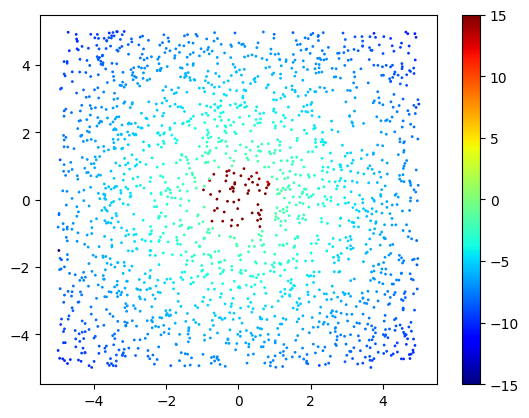

In [19]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot...
plt.scatter(X[:,0], X[:,1], c=y, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()

In [9]:
print(len(X))
print(len(y))

2000
2000


In [10]:
X

array([[-0.44862086, -3.5639553 , -0.01976328, -1.018363  ,  0.44989693,
         0.8608505 ],
       [ 2.1834652 , -1.0751164 , -1.4446267 , -3.3683279 , -1.1456506 ,
         2.5462298 ],
       [-3.8266828 ,  2.3283496 ,  3.1131845 ,  2.8994792 , -3.545898  ,
         1.5996921 ],
       ...,
       [ 3.2111986 , -2.3585057 ,  0.07735627,  4.626278  ,  0.3959862 ,
         0.7164214 ],
       [-0.5001837 , -2.2065208 ,  0.4526554 , -3.464559  ,  3.6508636 ,
         2.7287967 ],
       [ 4.3661203 , -3.754396  ,  2.655438  , -2.2976801 , -2.1925979 ,
         2.2045698 ]], dtype=float32)

In [30]:
#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(12)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(6)(l2)
#     l4 = jax.nn.relu(l3)

#     l5= hk.Linear(1)(l4)

#     return l5

#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(18)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(1)(l2)

    return l3.ravel()


# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse





optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)
batch_size = 100

# for epoch in range(3000):
#     loss, grads = jax.value_and_grad(loss_fn)(params,X=X,y=y)
#     print("progress:", "epoch:", epoch, "loss",loss)
#     updates, opt_state = optimizer.update(grads, opt_state, params)
#     params = optax.apply_updates(params, updates)

for epoch in range(10):
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.9)
    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        print("progress:", "epoch:", epoch, "loss",loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        
    
# After training
print("estimation of the parameters:")
print(params)



progress: epoch: 0 loss 4.430926
progress: epoch: 0 loss 5.4995313
progress: epoch: 0 loss 3.3114085
progress: epoch: 0 loss 4.146916
progress: epoch: 0 loss 1.0763066
progress: epoch: 0 loss 3.5607905
progress: epoch: 0 loss 4.148965
progress: epoch: 0 loss 5.022511
progress: epoch: 0 loss 3.8885496
progress: epoch: 0 loss 2.0306587
progress: epoch: 0 loss 3.1767397
progress: epoch: 0 loss 1.9647806
progress: epoch: 0 loss 3.939183
progress: epoch: 0 loss 1.0177369
progress: epoch: 0 loss 3.044482
progress: epoch: 0 loss 0.93537897
progress: epoch: 0 loss 2.4957027
progress: epoch: 0 loss 3.7790163
progress: epoch: 0 loss 1.9315623
progress: epoch: 0 loss 4.8619876
progress: epoch: 1 loss 3.7247124
progress: epoch: 1 loss 4.653028
progress: epoch: 1 loss 2.691378
progress: epoch: 1 loss 3.62223
progress: epoch: 1 loss 0.65004236
progress: epoch: 1 loss 2.89371
progress: epoch: 1 loss 3.5591717
progress: epoch: 1 loss 4.529092
progress: epoch: 1 loss 3.4704835
progress: epoch: 1 loss 1

In [12]:
test_state = env.reset()
input = np.hstack([test_state['attacker'], test_state['defender']])
estimate  = forward(X=input, params=params)
print("estimate", estimate)

reset {'attacker': array([ 1.759152 , -3.7645855,  1.7534684], dtype=float32), 'defender': array([-4.1313405 , -3.2239897 ,  0.11848879], dtype=float32)}
estimate [-3.879828]


In [13]:
env = TwoPlayerDubinsCarEnv()
state = env.reset()
done = False
max_iter = 100
counter = 0
print(env.car_position)
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for d_action in range(env.action_space['defender'].n):
        state_ , reward, done, info = env.state_action_step(state, d_action, 'defender')
        defender_actions = []
        for a_action in range(env.action_space['attacker'].n):
            next_state, reward, _, _ = env.state_action_step(state_, a_action, 'attacker')
            input = np.hstack([next_state['attacker'], next_state['defender']])
            estimate  = forward(X=input, params=params)
            print('estimate', estimate, 'actual', reward)
            possible_actions.append([d_action, a_action, estimate[0]])
        pa = np.array(possible_actions)
    cand_attack_actions = np.argmax(pa.T,axis=0)
    best_defender_action =  np.argmin(np.max(pa.T,axis=0))
    best_attacker_action = cand_attack_actions[best_defender_action]
    print(counter)




    state, reward, done, _ = env.step(best_defender_action, 'defender')
    state, reward, done, _ = env.step(best_attacker_action, 'attacker')

    env.render()
    
env.make_gif()

reset {'attacker': array([-2.288628  , -2.6152785 ,  0.08513633], dtype=float32), 'defender': array([ 3.9687836,  2.060748 , -1.1909049], dtype=float32)}
{'attacker': array([-2.288628  , -2.6152785 ,  0.08513633], dtype=float32), 'defender': array([ 3.9687836,  2.060748 , -1.1909049], dtype=float32)}
estimate [-3.6566129] actual -3.449660713445011
estimate [-3.6532307] actual -3.424327373280748
estimate [-3.6181078] actual -3.396139820343856
1


/home/apraka15/Documents/Projects/Reach-Avoid/gym-examples/.env/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/apraka15/Documents/Projects/Reach-Avoid/gym-examples/.env/lib/python3.10/site-packages/imageio/plugins/tifffile.py:189: DeprecationWarning: ImageIO's vendored tifffile backend is deprecated and will be removed in ImageIO v3. Install the tifffile directly: `pip install imageio[tifffile]`
  warnings.warn(


estimate [-3.6507072] actual -3.350311114754569
estimate [-3.6480713] actual -3.329618907616964
estimate [-3.613657] actual -3.305778022840319
1
estimate [-3.618379] actual -3.2699062420481346
estimate [-3.6165175] actual -3.254450161365461
estimate [-3.582849] actual -3.2356097126825034
1
estimate [-3.6433268] actual -3.210779734184343
estimate [-3.6422606] actual -3.2010469133100155
estimate [-3.609367] actual -3.18775903625694
2
estimate [-3.641097] actual -3.1747830977394433
estimate [-3.6408381] actual -3.171105620525271
estimate [-3.6087399] actual -3.1637719643818962
2
estimate [-3.613605] actual -3.1631049911709463
estimate [-3.6141558] actual -3.16562286295719
estimate [-3.5828648] actual -3.164455488114176
2
estimate [-3.6435022] actual -3.1761416254516326
estimate [-3.6444006] actual -3.184784979353127
estimate [-3.615924] actual -3.1897864457516527
3
estimate [-3.6431918] actual -3.213451184685638
estimate [-3.644967] actual -3.227946295533583
estimate [-3.6173768] actual -

In [14]:
possible_actions

[[0, 0, Array(-4.607669, dtype=float32)],
 [0, 1, Array(-4.616072, dtype=float32)],
 [0, 2, Array(-4.5854297, dtype=float32)],
 [1, 0, Array(-4.716869, dtype=float32)],
 [1, 1, Array(-4.724693, dtype=float32)],
 [1, 2, Array(-4.693565, dtype=float32)],
 [2, 0, Array(-4.797908, dtype=float32)],
 [2, 1, Array(-4.805068, dtype=float32)],
 [2, 2, Array(-4.77336, dtype=float32)]]

In [15]:
import pandas as pd
df = pd.DataFrame(possible_actions, columns=['defender', 'attacker','value'])
df


,defender,attacker,value
0,0,0,-4.607669
1,0,1,-4.616072
2,0,2,-4.5854297
3,1,0,-4.716869
4,1,1,-4.724693
5,1,2,-4.693565
6,2,0,-4.797908
7,2,1,-4.805068
8,2,2,-4.77336


In [16]:
pa = np.array(possible_actions)
pa = pa[:,2].reshape(3,3)
pa

array([[-4.60766888, -4.61607218, -4.58542967],
       [-4.71686888, -4.72469282, -4.69356489],
       [-4.79790783, -4.80506802, -4.77335978]])

In [17]:
best_attacker_moves = np.argmax(pa.T,axis=0)

best_defender_move =  np.argmin(np.max(pa.T,axis=0))

best_attacker_move = best_attacker_moves[best_defender_move]
print(best_defender_move,best_attacker_move)


2 2


In [18]:
np.min(np.max(pa.T,axis=0))

-4.773359775543213

In [ ]:
possible_actions